In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kobe = pd.read_csv("data.csv")
kobe.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [3]:
kobe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

## 1.Data Preprocessing

In [4]:
pd.isnull(kobe.shot_made_flag).sum() 
#pd.notnull(kobe.shot_made_flag).sum() 

5000

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'latitude and longtitude')

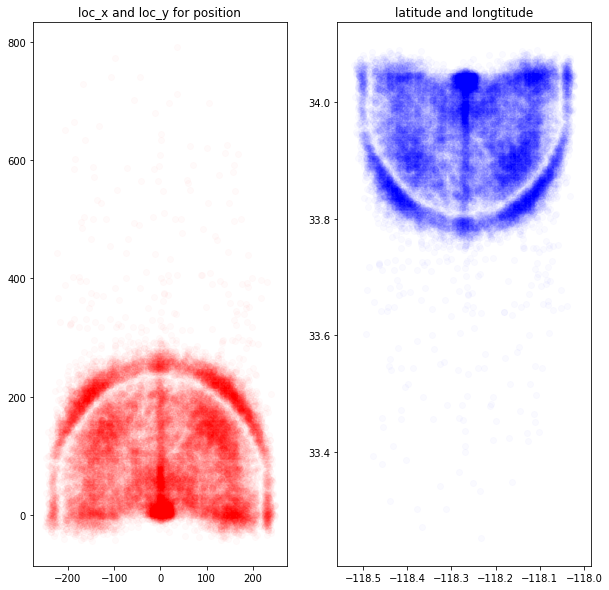

In [5]:
#plot the loc_x and loc_y for position
plt.figure(figsize = (10,10))

#loc_x and loc_y
plt.subplot(121)
plt.scatter(kobe.loc_x, kobe.loc_y, color='R', alpha=0.02)
plt.title('loc_x and loc_y for position')

#Lat and Lon
plt.subplot(122)
plt.scatter(kobe.lon, kobe.lat, color='B', alpha=0.02)
plt.title('latitude and longtitude')

In [6]:
kobe['dist'] = np.sqrt(kobe['loc_x']**2 + kobe['loc_y']**2)

#convert loc_x and loc_y, 
loc_x_zero = kobe['loc_x'] == 0

#print (loc_x_zero)
kobe['angle'] = np.array([0]*len(kobe))
kobe['angle'][~loc_x_zero] = np.arctan(kobe['loc_y'][~loc_x_zero] / kobe['loc_x'][~loc_x_zero])
kobe['angle'][loc_x_zero] = np.pi /2

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
kobe.remaining_time = kobe.minutes_remaining * 60 + kobe.seconds_remaining

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [8]:
kobe.shot_type.value_counts()

2PT Field Goal    24271
3PT Field Goal     6426
Name: shot_type, dtype: int64

In [9]:
kobe.combined_shot_type.unique()

array(['Jump Shot', 'Dunk', 'Layup', 'Tip Shot', 'Hook Shot', 'Bank Shot'],
      dtype=object)

### 1.1 Check feature 'distance' and define 'dist'

Text(0.5, 1.0, 'dist v.s. distance')

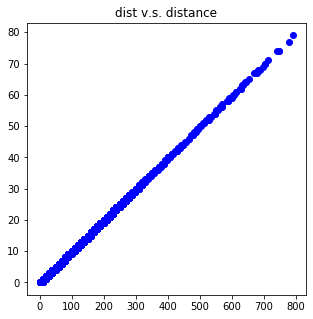

In [10]:
plt.figure(figsize = (5,5))

plt.scatter(kobe.dist, kobe.shot_distance, color = 'B')
plt.title('dist v.s. distance')

#linear correlate: 

Text(0.5, 1.0, 'shot_zone_range')

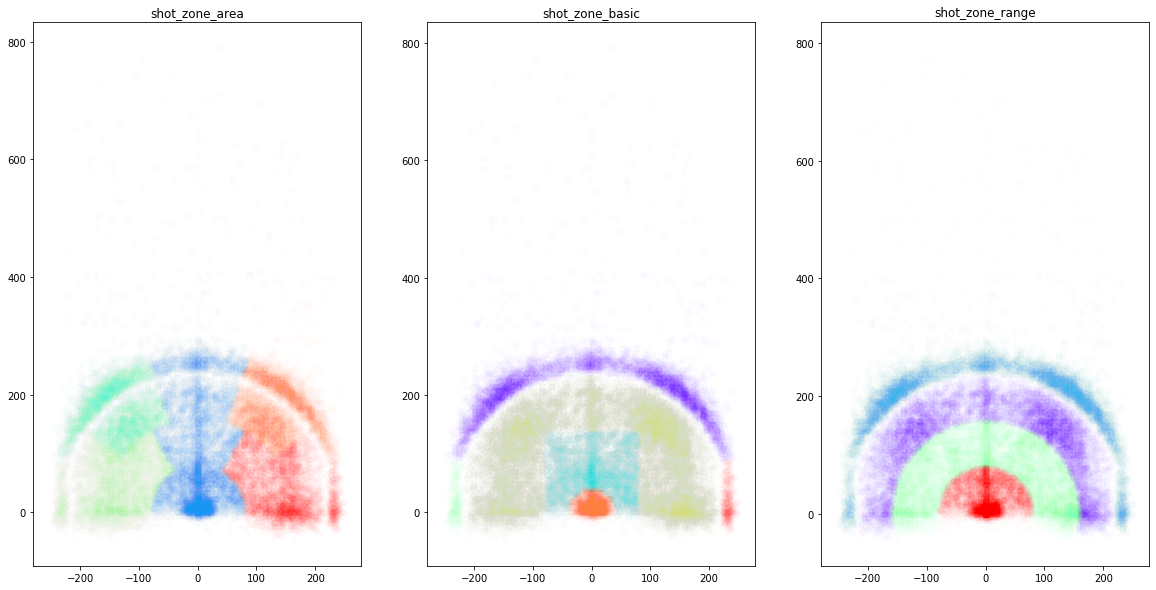

In [11]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0,1,len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color = c, alpha=0.01)
        
#shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

#shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

#shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [12]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range',
        'shot_zone_basic', 'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining',
        'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']

for drop in drops:
    kobe = kobe.drop(drop, 1)

In [13]:
pd.get_dummies(kobe.combined_shot_type, prefix = 'cst')[0:2] 
#[0:2] is show only two rows

,cst_Bank Shot,cst_Dunk,cst_Hook Shot,cst_Jump Shot,cst_Layup,cst_Tip Shot
0,0,0,0,1,0,0
1,0,0,0,1,0,0


In [14]:
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']

for var in categorical_vars:
    kobe = pd.concat([kobe, pd.get_dummies(kobe[var], prefix = var)], 1)
    kobe = kobe.drop(var, 1)

## 2. Modeling

In [15]:
#train test split and fill nan
train_kobe = kobe[pd.notnull(kobe['shot_made_flag'])]
train_y = train_kobe['shot_made_flag']
train_x = train_kobe.drop('shot_made_flag', 1)

test_x = kobe[pd.isnull(kobe['shot_made_flag'])]
test_y = test_x['shot_made_flag']
test_x = test_x.drop('shot_made_flag',1)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import time

In [17]:
range_m = np.logspace(0, 2, num=3).astype(int)
print(range_m)
range_n = np.logspace(0, 2, num=5).astype(int)
print(range_n)

[  1  10 100]
[  1   3  10  31 100]


### 2.1 Tune n_estimators for random forest

In [18]:
min_score = 100000
best_n = []
scores_n = []

for n in range_n:
    rf_score = 0
    rf = RandomForestClassifier(n_estimators=n)
    
    kfold = KFold(5, True)
    for train_k, test_k in kfold.split(train_x):
        rf.fit(train_x.iloc[train_k], train_y.iloc[train_k])
        #rf_score += rf.score(train_x.iloc[test_k], train_y.iloc[train_k]) /10
        pred = rf.predict(train_x.iloc[test_k])
        rf_score += log_loss(train_y.iloc[test_k], pred) /10
    scores_n.append(rf_score)
    if rf_score < min_score:
        min_score = rf_score
        best_n = n
        
print(best_n, min_score)

100 6.120989748830972


Text(0.5, 0, 'n_estimators')

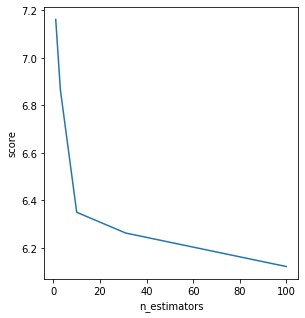

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('n_estimators')

In [31]:
#find best max_depth for RandomForestClassifier

min_score = 100000
best_m = 0
score_m = []

for m in range_m:
    rf_score = 0
    rfc = RandomForestClassifier(max_depth=m, n_estimators = 100)
    kfold = KFold(5, True)
    
    for train_k, test_k in kfold.split(train_x):
        rfc.fit(train_x.iloc[train_k], train_y.iloc[train_k])
        
        pred = rfc.predict(train_x.iloc[test_k])
        rf_score += log_loss(train_y.iloc[test_k], pred) /10
    score_m.append(rf_score)
    if rf_score < min_score:
        min_score = rf_score
        best_m = m
print(best_m, min_score)

10 5.505380380871755


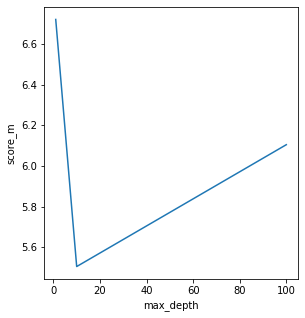

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(range_m, score_m)
plt.ylabel("score_m")
plt.xlabel("max_depth")
plt.show()

In [34]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)